Create matching

In [1]:
import pickle
from sklearn.utils import shuffle
import pandas as pd

with open( '/share/hel/datasets/fs/nlp/text_classification_bias/bios/BIOS.pkl', 'rb') as file:
    bios_dicts = pickle.load(file)
df = pd.DataFrame(bios_dicts)

df.drop(['path','name','start_pos','URI','title'], axis=1, inplace=True)
df['raw_title'] = df['raw_title'].map(lambda x: x.lower())
raw_bio =[]
bio = []
for i in range(len(df)):
    raw_bio.append(df['raw'][i].replace(df['raw_title'][i],'_'))
    bio.append(df['bio'][i].replace(df['raw_title'][i],'_'))
df['raw'] = raw_bio
df['bio'] = bio
print(len(df))


361634


In [2]:
import pandas as pd
import glob

path = '/share/hel/datasets/jobiqo/talent.com/UK/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    frame = pd.read_csv(filename, index_col=None, header=0)
    li.append(frame)

uk_data = pd.concat(li, axis=0, ignore_index=True)
uk_data.drop(['company','city','state','country','date','time','jobid'], axis=1, inplace=True)
uk_data['title'] = uk_data['title'].map(lambda x: x.lower())
print(len(uk_data))
uk_data.drop_duplicates(subset="description",  keep=False, inplace=True)
new_uk_data = uk_data[uk_data['title'].isin(df.raw_title.unique())]
print(len(new_uk_data))

903011
2109


In [3]:
new_uk_data['description'] = new_uk_data['description'].replace('\n',' ', regex=True)

/tmp/deepak/ipykernel_39660/462123052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_uk_data['description'] = new_uk_data['description'].replace('\n',' ', regex=True)


In [4]:
new_uk_data['title'].value_counts()

software engineer           522
senior software engineer    405
dentist                     279
accountant                  162
teacher                     152
architect                   146
nurse                       141
paralegal                    96
painter                      70
psychologist                 33
personal trainer             23
dietitian                    22
interior designer            18
photographer                 16
psychotherapist               4
journalist                    4
assistant professor           4
attorney                      3
associate professor           3
yoga instructor               2
model                         1
surgeon                       1
physician                     1
nutritionist                  1
Name: title, dtype: int64

In [5]:
titles_remove = ['physician', 'nutritionist', 'surgeon', 'model', 'yoga instructor', 'attorney', 'associate professor', 'journalist', 'assistant professor', 'psychotherapist' ]

for title in titles_remove:
    new_uk_data = new_uk_data.drop(new_uk_data[new_uk_data['title']==title].index)

In [6]:
new_uk_data['title'].value_counts()

software engineer           522
senior software engineer    405
dentist                     279
accountant                  162
teacher                     152
architect                   146
nurse                       141
paralegal                    96
painter                      70
psychologist                 33
personal trainer             23
dietitian                    22
interior designer            18
photographer                 16
Name: title, dtype: int64

In [7]:
new_df = df[df['raw_title'].isin(uk_data.title.unique())]
new_df

,raw,raw_title,gender,bio
0,* Nora Fisher Onar is an _ of international re...,assistant professor,F,_ is also a Ronald D. Asmus Policy Entrepreneu...
2,Dr. Shawn Zelig Aster is an _ of Bible at Yesh...,assistant professor,M,Dr. _ has held teaching and research positions...
3,Brittany McCandless is a _ with a print and br...,journalist,F,_ currently works on CNN’s newest primetime sh...
4,Arturo Toledo is an Architect. He runs a bouti...,architect,M,_ runs a boutique design studio attending clie...
5,Jan De Clercq is a solution _ working for the ...,architect,M,"_ focuses on cloud security, identity and acce..."
...,...,...,...,...
361629,Fernando Quesada is an Attorney at-law admitte...,attorney,M,_ focuses _ practice in all forms of Energy (i...
361630,Jeffrey Kucik is an _ in the School of Governm...,assistant professor,M,_ maintains the trade policy site www.trademon...
361631,Leslie E. Seawright is an Assistant Professor ...,assistant professor,F,"_ teaches courses in Technical Writing, Compos..."
361632,Paul Bird is a Chartered Accountant with over ...,accountant,M,_ has been responsible for many facets of fina...


In [8]:
titles_remove = ['physician', 'nutritionist', 'surgeon', 'model', 'yoga instructor', 'attorney', 'associate professor', 'journalist', 'assistant professor', 'psychotherapist' ]

for title in titles_remove:
    new_df = new_df.drop(new_df[new_df['raw_title']==title].index)

new_df

,raw,raw_title,gender,bio
4,Arturo Toledo is an Architect. He runs a bouti...,architect,M,_ runs a boutique design studio attending clie...
5,Jan De Clercq is a solution _ working for the ...,architect,M,"_ focuses on cloud security, identity and acce..."
6,Shane Lavalette is a _ currently living in Som...,photographer,M,_ received _ BFA from Tufts University in part...
7,"Edmund J. Bourne, PhD, is a _ in northern Cali...",psychologist,M,"_ is author of several books, including the be..."
10,Lama Kali Ma is a _ in the rare lineage of Bud...,teacher,F,_ teachings get straight to the heart of Tantr...
...,...,...,...,...
361611,Benjamin Filarski is a French/Polish _ (b.1993...,photographer,M,_ studied sociology and political sciences at ...
361614,"Alice Sumo is a respected _ in Liberia, where ...",nurse,F,"In _ three-decade career, _ has seen two civil..."
361616,Matthias Naab is a software _ at the Fraunhofe...,architect,M,_ is responsible for the development of _ure m...
361622,Marina V. Umali is an Interior Designer & Feng...,interior designer,F,_ creates custom solutions for _ clients using...


In [9]:
import pickle

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/bios.pkl', 'wb') as f:
    pickle.dump(new_df, f)

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'wb') as f:
    pickle.dump(new_uk_data, f)

BIOS counterfactual and cleaning

In [1]:
import pickle
import pandas as pd

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/bios.pkl', 'rb') as file:
    dicts = pickle.load(file)
bios = pd.DataFrame(dicts)
#bios = pd.DataFrame(dicts).reset_index()
#bios = bios.drop('index', axis=1)

with open( '/share/hel/datasets/fs/nlp/text_classification_bias/bios/BIOS.pkl', 'rb') as file:
    dicts = pickle.load(file)
original_bios = pd.DataFrame(dicts)

import regex as re
from tqdm.autonotebook import tqdm

male_words = ['mr','his','he','him','himself']
female_words = ['mrs','hers','she','her','herself']

bio_list = []
counterfactual_list = []

for id in tqdm(bios.index):
    bio_string = bios['raw'][id]
    name_list = list(original_bios['name'][id])
    if len(name_list[1])==1:
        name_list[1] = name_list[1]+'.'
    if '' in name_list:
        name_list.remove('')


    bio_string = re.sub(' '.join(name_list), 'NAME',bio_string,flags=re.I)
    for name in name_list:
            bio_string = re.sub(r'\s'+name+r'\s', ' NAME ',bio_string,flags=re.I)
    if bios['gender'][id]=='M':
        bio_string = re.sub('NAME', 'Bob',bio_string)
        bio_list.append(bio_string)
        for i in range(len(male_words)):
            bio_string = re.sub(r'\s'+male_words[i]+r'\s', ' '+female_words[i]+' ',bio_string,flags=re.I)

        bio_string = re.sub('Bob', 'Alice',bio_string)
    elif bios['gender'][id]=='F':
        bio_string = re.sub('NAME', 'Alice',bio_string)
        bio_list.append(bio_string)
        for i in range(len(male_words)):
            bio_string = re.sub(r'\s'+female_words[i]+r'\s',' '+ male_words[i]+' ',bio_string,flags=re.I)

        bio_string = re.sub('Alice', 'Bob',bio_string)
    counterfactual_list.append(bio_string)

bios['bio'] = bio_list
bios['counter_bio'] = counterfactual_list


bios = bios.reset_index()
bios = bios.drop('index', axis=1)

i=0
for job in bios['raw_title'].unique():
    print(job)
    if i==0:
        new_bios = pd.concat([bios[(bios['gender']=='F') & (bios['raw_title']==job)].sample(n=100,random_state=1),bios[(bios['gender']=='M') & (bios['raw_title']==job)].sample(n=100,random_state=1)])
    else:
        new_bios = pd.concat([new_bios, pd.concat([bios[(bios['gender']=='F') & (bios['raw_title']==job)].sample(n=100,random_state=1),bios[(bios['gender']=='M') & (bios['raw_title']==job)].sample(n=100,random_state=1)])])
    i=i+1

new_bios = new_bios.reset_index()
new_bios = new_bios.drop('index', axis=1)

anonymous_bio = []
anonymous_counter_bio = []
for i in range(2800):
    anonymous_bio.append(re.sub(new_bios['raw_title'][i], '_', new_bios['bio'][i],flags=re.I))
    anonymous_counter_bio.append(re.sub(new_bios['raw_title'][i], '_', new_bios['counter_bio'][i],flags=re.I))

new_bios['bio'] = anonymous_bio
new_bios['counter_bio'] = anonymous_counter_bio

new_bios = new_bios.reset_index()
new_bios = new_bios.drop('index', axis=1)

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/new_bios.pkl', 'wb') as f:
    pickle.dump(new_bios, f)

/tmp/deepak/ipykernel_19093/268416929.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 112385/112385 [01:10<00:00, 1592.58it/s]


architect
photographer
psychologist
teacher
nurse
software engineer
painter
personal trainer
dietitian
dentist
interior designer
senior software engineer
accountant
paralegal


Split data

In [24]:
import pickle
import pandas as pd

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/new_bios.pkl', 'rb') as file:
    dicts = pickle.load(file)
bios = pd.DataFrame(dicts).reset_index()
bios.drop('index', axis=1, inplace=True)

In [25]:
bios['raw_title'].value_counts()

architect                   200
photographer                200
psychologist                200
teacher                     200
nurse                       200
software engineer           200
painter                     200
personal trainer            200
dietitian                   200
dentist                     200
interior designer           200
senior software engineer    200
accountant                  200
paralegal                   200
Name: raw_title, dtype: int64

In [26]:
#Load Data

from sklearn.model_selection import train_test_split

train, val_test = train_test_split(bios,random_state=100, test_size=0.30, stratify=bios['raw_title'], shuffle=True)
test, val = train_test_split(val_test,random_state=100, test_size=0.333, stratify=val_test['raw_title'], shuffle=True)
train = train.reset_index()
train.drop('index', axis=1, inplace=True)
val = val.reset_index()
val.drop('index', axis=1, inplace=True)
test = test.reset_index()
test.drop('index', axis=1, inplace=True)

In [27]:
len(test),len(val),len(train)

(560, 280, 1960)

In [28]:
import pickle

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/train.pkl', 'wb') as f:
    pickle.dump(train, f)

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/val.pkl', 'wb') as f:
    pickle.dump(val, f)

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/test.pkl', 'wb') as f:
    pickle.dump(test, f)

Pickle to Jason File

In [7]:
import pickle
import pandas as pd

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'rb') as file:
    dicts = pickle.load(file)
uk_jobs = pd.DataFrame(dicts)
uk_jobs = pd.DataFrame(dicts).reset_index()
uk_jobs = uk_jobs.drop('index', axis=1)

In [8]:
train

,raw,raw_title,gender,bio,counter_bio
0,Dr Ja Intarasoot is a Paediatric Dentist (Chil...,dentist,F,Dr Alice is a Paediatric _ (Children's _). She...,Dr Bob is a Paediatric _ (Children's _). he sp...
1,Tabitha Beatty-Garcia is a Senior Accountant f...,accountant,F,Alice is a Senior _ for Read King. In this rol...,"Bob is a Senior _ for Read King. In this role,..."
2,Martin Binks is a clinical _ at Texas Tech Uni...,psychologist,M,Bob is a clinical _ at Texas Tech University i...,Alice is a clinical _ at Texas Tech University...
3,Matt Harrison is a Senior Software Engineer wi...,senior software engineer,M,Bob is a _ with SpikeSource. When not busy pro...,Alice is a _ with SpikeSource. When not busy p...
4,Thornton Abel is a lesser-known _ but still qu...,architect,M,Bob is a lesser-known _ but still quite notabl...,Alice is a lesser-known _ but still quite nota...
...,...,...,...,...,...
1955,Rachell Ekroos is a family _ practitioner spec...,nurse,F,Alice is a family _ practitioner specializing ...,Bob is a family _ practitioner specializing in...
1956,Swami Bodhananda Sarasvati is an accomplished ...,teacher,M,"Bob is an accomplished _ of Vedanta, meditatio...","Alice is an accomplished _ of Vedanta, meditat..."
1957,Renee Cox is a _ whose work display a deep con...,photographer,F,Alice is a _ whose work display a deep concern...,Bob is a _ whose work display a deep concern f...
1958,Katie Haneke is a Registered Dietitian working...,dietitian,F,Alice is a Registered _ working at the Grand R...,Bob is a Registered _ working at the Grand Riv...


In [9]:
uk_jobs

,title,description
0,senior software engineer,The Senior .net Developer will be part of the ...
1,nurse,Registered Nurse - Good CQC - Paid breaks - ...
2,nurse,It’s more than a possibility Nurse - U...
3,dentist,We’re looking for an Associate Dentist to wor...
4,software engineer,Role Overview Looking for the next step...
...,...,...
2080,dentist,Description Associate Dentist required for ext...
2081,senior software engineer,MediaMathhelps the world's top brands deliver...
2082,photographer,"Photographer Altnagelvin, Londonderry BT..."
2083,personal trainer,Rare opportunity to join The Chapel - Luxury...


In [10]:
import pickle
import pandas as pd

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'rb') as file:
    dicts = pickle.load(file)
uk_jobs = pd.DataFrame(dicts)
uk_jobs = pd.DataFrame(dicts).reset_index()
uk_jobs = uk_jobs.drop('index', axis=1)

home_path = '/share/hel/datasets/jobiqo/talent.com/JobRec/BM25/'

uk_jobs['id'] = ['doc'+str(i+1) for i in range(len(uk_jobs))]

#bios_true_gender = bios.drop(['raw','counter_bio'],axis='columns')
#bios_true_gender.rename(columns = {'bio':'contents'}, inplace = True)
#bios_true_gender.to_json(home_path + 'counterfactual_gender/bios.json', orient='records')


uk_jobs.rename(columns = {'description':'contents'}, inplace = True)
uk_jobs.to_json(home_path + 'uk_jobs.json', orient='records')

Get TSV

In [11]:
import pickle
import pandas as pd

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/train.pkl', 'rb') as f:
    dicts = pickle.load(f)
    data = pd.DataFrame(dicts)
    data = data['bio']
    data.to_csv('/share/hel/datasets/jobiqo/talent.com/JobRec/train.tsv', header=False, sep="\t") 


with open('/share/hel/datasets/jobiqo/talent.com/JobRec/val.pkl', 'rb') as f:
    dicts = pickle.load(f)
    data = pd.DataFrame(dicts)
    data = data['bio']
    data.to_csv('/share/hel/datasets/jobiqo/talent.com/JobRec/val.tsv', header=False, sep="\t")

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/test.pkl', 'rb') as f:
    dicts = pickle.load(f)
    data = pd.DataFrame(dicts)
    data = data['bio']
    data.to_csv('/share/hel/datasets/jobiqo/talent.com/JobRec/test.tsv', header=False, sep="\t")

GEt BM25 hits

In [12]:
!python -m pyserini.index.lucene \
  --collection JsonCollection \
  --input /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/ \
  --index /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/indexes \
  --generator DefaultLuceneDocumentGenerator \
  --threads 1 \
  --storePositions --storeDocvectors --storeRaw

2024-01-25 00:26:08,227 INFO  [main] index.IndexCollection (IndexCollection.java:391) - Setting log level to INFO
2024-01-25 00:26:08,229 INFO  [main] index.IndexCollection (IndexCollection.java:394) - Starting indexer...
2024-01-25 00:26:08,229 INFO  [main] index.IndexCollection (IndexCollection.java:395) - ============ Loading Parameters ============
2024-01-25 00:26:08,229 INFO  [main] index.IndexCollection (IndexCollection.java:396) - DocumentCollection path: /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/
2024-01-25 00:26:08,230 INFO  [main] index.IndexCollection (IndexCollection.java:397) - CollectionClass: JsonCollection
2024-01-25 00:26:08,230 INFO  [main] index.IndexCollection (IndexCollection.java:398) - Generator: DefaultLuceneDocumentGenerator
2024-01-25 00:26:08,230 INFO  [main] index.IndexCollection (IndexCollection.java:399) - Threads: 1
2024-01-25 00:26:08,230 INFO  [main] index.IndexCollection (IndexCollection.java:400) - Language: en
2024-01-25 00:26:08,231 INFO  [

In [13]:
!python -m pyserini.search.lucene  --index /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/indexes --topics /share/hel/datasets/jobiqo/talent.com/JobRec/train.tsv --output /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/train_hits.txt  --bm25

Running /share/hel/datasets/jobiqo/talent.com/JobRec/train.tsv topics, saving to /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/train_hits.txt...
100%|███████████████████████████████████████| 1960/1960 [03:05<00:00, 10.56it/s]


In [14]:
!python -m pyserini.search.lucene  --index /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/indexes --topics /share/hel/datasets/jobiqo/talent.com/JobRec/val.tsv --output /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/val_hits.txt  --bm25

Running /share/hel/datasets/jobiqo/talent.com/JobRec/val.tsv topics, saving to /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/val_hits.txt...
100%|█████████████████████████████████████████| 280/280 [00:31<00:00,  9.00it/s]


In [15]:
!python -m pyserini.search.lucene  --index /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/indexes --topics /share/hel/datasets/jobiqo/talent.com/JobRec/test.tsv --output /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/test_hits.txt  --bm25

Running /share/hel/datasets/jobiqo/talent.com/JobRec/test.tsv topics, saving to /share/hel/datasets/jobiqo/talent.com/JobRec/BM25/test_hits.txt...
100%|█████████████████████████████████████████| 560/560 [00:52<00:00, 10.60it/s]


Neutrality Score

In [62]:
import pickle
import regex as re
from nltk.corpus import wordnet as wn
import pandas as pd
from nltk.corpus import stopwords
import numpy as np

cachedStopWords = stopwords.words("english")

def cleaner(s):
    s = s.replace('[SEP]','')
    return re.sub(r'[^A-Za-z0-9 ]+', '', s).strip()

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'rb') as file:
    dicts = pickle.load(file)

uk_jobs = pd.DataFrame(dicts).reset_index()
uk_jobs = uk_jobs.drop('index', axis=1)

dictionary_jobs = {}
for job in uk_jobs['title'].unique():
#for job in ['senior software engineer']:
    print(job)
    with open( '/home/deepak/RecSys2023/IG_bert/'+job+'.pkl', 'rb') as file:
        dictionary_dictionary = pickle.load(file)
        dictionary_words = {}    
        for key in dictionary_dictionary.keys():
            for word in dictionary_dictionary[key]:
                if word not in cachedStopWords and not word.isdigit() and len(cleaner(word))>2 and wn.synsets(word)!=[] :
                    if word in dictionary_words.keys():
                        dictionary_words[cleaner(word)].append(dictionary_dictionary[key][word])
                    else:
                        dictionary_words[cleaner(word)] = [dictionary_dictionary[key][word].cpu().detach().numpy()]

        for key in dictionary_words.keys():
            dictionary_words[key] =  float(sum(dictionary_words[key])/len(dictionary_words[key])) # denominator non zero
        
        #dictionary_jobs[job]=dictionary_words
        dictionary_words = scale(dictionary_words)
        dictionary_jobs[job] = {key:testue for key,testue in dictionary_words.items() if testue >sorted(dictionary_words.values(),reverse=True)[20]}

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/dictionary_jobs.pkl', 'wb') as f:
    pickle.dump(dictionary_jobs, f)

senior software engineer
nurse
dentist
software engineer
accountant
dietitian
architect
personal trainer
teacher
painter
interior designer
psychologist
paralegal
photographer


In [60]:
maximum_value = 0.17714500148050216

for job in dictionary_jobs.keys():
    print((job,max(dictionary_jobs[job].values())))

('senior software engineer', 0.1172207813888931)
('nurse', 0.06828179091857516)
('dentist', 0.08215841962723916)
('software engineer', 0.10525064085267678)
('accountant', 0.07882090241370313)
('dietitian', 0.0938053599070877)
('architect', 0.06865257935928776)
('personal trainer', 0.07628798229823804)
('teacher', 0.0854685349399428)
('painter', 0.17714500148050216)
('interior designer', 0.07369410261140139)
('psychologist', 0.050920395138715414)
('paralegal', 0.08308844582818306)
('photographer', 0.08450208334770831)


In [42]:
def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}

In [61]:
def scale(d, target=1.0):
   #raw = max(d.values())
   raw = 0.17714500148050216

   factor = target/raw
   return {key:value*factor for key,value in d.items()}

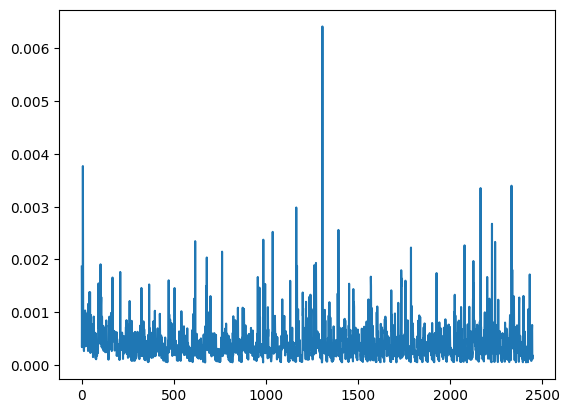

In [44]:
import matplotlib.pyplot as plt

ys = normalize(dictionary_words).values()
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()
# Make sure to close the plt object once done
plt.close()

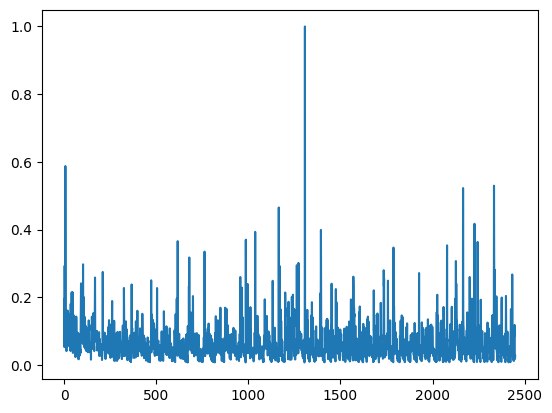

In [41]:
import matplotlib.pyplot as plt

ys = scale(dictionary_words).values()
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()
# Make sure to close the plt object once done
plt.close()

In [47]:
with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'rb') as file:
    dicts = pickle.load(file)
uk_jobs = pd.DataFrame(dicts)
uk_jobs = pd.DataFrame(dicts).reset_index()
uk_jobs = uk_jobs.drop('index', axis=1)

In [48]:
uk_jobs

,title,description,neutrality
0,senior software engineer,The Senior .net Developer will be part of the ...,0.940670
1,nurse,Registered Nurse - Good CQC - Paid breaks - ...,0.961643
2,nurse,It’s more than a possibility Nurse - U...,0.960256
3,dentist,We’re looking for an Associate Dentist to wor...,0.953347
4,software engineer,Role Overview Looking for the next step...,0.938174
...,...,...,...
2080,dentist,Description Associate Dentist required for ext...,0.957394
2081,senior software engineer,MediaMathhelps the world's top brands deliver...,0.942938
2082,photographer,"Photographer Altnagelvin, Londonderry BT...",0.956828
2083,personal trainer,Rare opportunity to join The Chapel - Luxury...,0.962939


In [65]:
import pickle


class DocNeutrality:
    def __init__(self, representative_words_path='/share/hel/datasets/jobiqo/talent.com/JobRec/dictionary_jobs.pkl',threshold=1):
        self.representative_words_path = representative_words_path
        self.threshold = threshold

        with open(self.representative_words_path, 'rb') as f:
            self.dictionary_jobs = pickle.load(f)


    def doc_neutrality(self, doc: str, job: str):
        bias = 0
        frequency = 0
        word_dict = self.dictionary_jobs[job]
        for word in word_dict.keys():
            bias = bias + (doc.count(word))*word_dict[word]
            frequency = frequency +doc.count(word)
        neutrality = 1-(bias/frequency) if frequency>self.threshold else 1
        
        return neutrality

In [66]:
uk_jobs['neutrality'] = [DocNeutrality().doc_neutrality(doc=uk_jobs['description'][i],job=uk_jobs['title'][i]) for i in range(len(uk_jobs))]

uk_jobs

,title,description,neutrality
0,senior software engineer,The Senior .net Developer will be part of the ...,0.665079
1,nurse,Registered Nurse - Good CQC - Paid breaks - ...,0.783469
2,nurse,It’s more than a possibility Nurse - U...,0.775642
3,dentist,We’re looking for an Associate Dentist to wor...,0.736639
4,software engineer,Role Overview Looking for the next step...,0.650989
...,...,...,...
2080,dentist,Description Associate Dentist required for ext...,0.759487
2081,senior software engineer,MediaMathhelps the world's top brands deliver...,0.677879
2082,photographer,"Photographer Altnagelvin, Londonderry BT...",0.756287
2083,personal trainer,Rare opportunity to join The Chapel - Luxury...,0.790785


In [68]:
#Scaled global

for job in uk_jobs['title'].unique():
    print((job, uk_jobs[uk_jobs['title']==job]['neutrality'].mean()))

('senior software engineer', 0.7441953584420418)
('nurse', 0.7809961133577886)
('dentist', 0.7131762917139647)
('software engineer', 0.7792235284563866)
('accountant', 0.7813289756794387)
('dietitian', 0.6862497273398168)
('architect', 0.7667260287108221)
('personal trainer', 0.7623521049867158)
('teacher', 0.7724829661646617)
('painter', 0.7125501829733393)
('interior designer', 0.7402656239505484)
('psychologist', 0.812831842829566)
('paralegal', 0.6441403902190833)
('photographer', 0.7128765433238317)


In [56]:
#Scaled job wise

for job in uk_jobs['title'].unique():
    print((job, uk_jobs[uk_jobs['title']==job]['neutrality'].mean()))

('senior software engineer', 0.6134259380410727)
('nurse', 0.43183324131417167)
('dentist', 0.38156811609205704)
('software engineer', 0.628416054651901)
('accountant', 0.5085506795685406)
('dietitian', 0.40750408537479893)
('architect', 0.3980806202033316)
('personal trainer', 0.44816817215863436)
('teacher', 0.5284404333838063)
('painter', 0.7125501829733393)
('interior designer', 0.37565361678345466)
('psychologist', 0.3488679066857722)
('paralegal', 0.24130544899289633)
('photographer', 0.39809193876678395)


In [13]:
#Frequency=100

for job in uk_jobs['title'].unique():
    print((job, uk_jobs[uk_jobs['title']==job]['neutrality'].mean()))

('senior software engineer', 0.9721685070209787)
('nurse', 0.971739821423259)
('dentist', 0.9619974830574787)
('software engineer', 0.9651597799598932)
('accountant', 0.9696511007220465)
('dietitian', 0.9761155581497634)
('architect', 0.9693150476997489)
('personal trainer', 0.9753457942092905)
('teacher', 0.9726669501218455)
('painter', 0.9657687387783639)
('interior designer', 0.9742323839316259)
('psychologist', 0.9798346145901449)
('paralegal', 0.9572115717169297)
('photographer', 0.9741526272314164)


In [5]:
#Frequency = 20

for job in uk_jobs['title'].unique():
    print((job, uk_jobs[uk_jobs['title']==job]['neutrality'].mean()))

('senior software engineer', 0.9546854863924962)
('nurse', 0.9612045561765298)
('dentist', 0.949190613771027)
('software engineer', 0.9608905516215465)
('accountant', 0.9612635210729913)
('dietitian', 0.9444207074851039)
('architect', 0.9586766820106158)
('personal trainer', 0.9579018632860338)
('teacher', 0.9596964947043995)
('painter', 0.9490797017372419)
('interior designer', 0.9539893535701827)
('psychologist', 0.9668440965209406)
('paralegal', 0.9369612488985086)
('photographer', 0.9491375148420133)


In [69]:
import pickle

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'wb') as f:
    pickle.dump(uk_jobs, f)

Train and validation set ready to load

In [2]:
import pickle
import pandas as pd
from tqdm.autonotebook import tqdm
import random

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/uk_jobs.pkl', 'rb') as file:
    dicts = pickle.load(file)

uk_jobs = pd.DataFrame(dicts).reset_index()
uk_jobs = uk_jobs.drop('index', axis=1)


with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/train.pkl', 'rb') as file:
    dicts = pickle.load(file)
bios_train = pd.DataFrame(dicts)

with open( '/share/hel/datasets/jobiqo/talent.com/JobRec/val.pkl', 'rb') as file:
    dicts = pickle.load(file)
bios_val = pd.DataFrame(dicts)


val_hits = pd.read_csv('/share/hel/datasets/jobiqo/talent.com/JobRec/BM25/val_hits.txt', sep=' ', header=None, names=['query_id', 'Q0', 'doc_id', 'rank', 'score','Anserini'])
train_hits = pd.read_csv('/share/hel/datasets/jobiqo/talent.com/JobRec/BM25/train_hits.txt', sep=' ', header=None, names=['query_id', 'Q0', 'doc_id', 'rank', 'score','Anserini'])
val_hits = val_hits.drop(['Q0','rank','score','Anserini'], axis='columns')
val_hits['doc_id'] = val_hits['doc_id'].replace('doc','',regex=True).astype(int)
train_hits = train_hits.drop(['Q0','rank','score','Anserini'], axis='columns')
train_hits['doc_id'] = train_hits['doc_id'].replace('doc','',regex=True).astype(int)

/tmp/deepak/ipykernel_51062/108992293.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [20]:

#In Train for every datapoint with label 1 we add 4 negative samples
from sentence_transformers import InputExample

train_samples = []

for id in tqdm(range(len(bios_train))):

    new_uk_jobs = uk_jobs.loc[train_hits[train_hits['query_id']==id]['doc_id']-1]

    query = bios_train['bio'][id]
    job = bios_train['raw_title'][id]
    
    pos_ad= new_uk_jobs.loc[(new_uk_jobs.title == job)][['description','neutrality']].sample(n=1)
    train_samples.append(InputExample(texts=[query, pos_ad['description'].values[0]], label=1, gender=pos_ad['neutrality'].values[0]))
    for looper in range(4):
        neg_passage = new_uk_jobs.loc[new_uk_jobs.title != job][['description','neutrality']].sample(n=1)
        train_samples.append(InputExample(texts=[query, neg_passage['description'].values[0]],label=0, gender=neg_passage['neutrality'].values[0]))

100%|██████████| 1960/1960 [00:14<00:00, 135.52it/s]


In [21]:
print(len(train_samples))

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/train_samples.pkl', 'wb') as f:
    pickle.dump(train_samples, f)

9800


In [13]:
# MAE loss fairness, bceloss task

dev_samples = {}

for id in tqdm(range(len(bios_val))):

    new_uk_jobs = uk_jobs.loc[val_hits[val_hits['query_id']==id]['doc_id']-1]

    query = bios_val['bio'][id]
    job = bios_val['raw_title'][id]

    dev_samples[id] = {'query': query, 'positive': set(), 'negative': set()}

    pos_passage = random.choice(list(new_uk_jobs.loc[new_uk_jobs.title == job]['description']))

    neg_passage = random.choice(list(new_uk_jobs.loc[new_uk_jobs.title != job]['description']))


    dev_samples[id]['positive'].add(pos_passage)
    dev_samples[id]['negative'].add(neg_passage)

100%|██████████| 280/280 [00:00<00:00, 333.55it/s]


In [15]:
print(len(dev_samples))

with open('/share/hel/datasets/jobiqo/talent.com/JobRec/dev_samples.pkl', 'wb') as f:
    pickle.dump(dev_samples, f)

280


Seeds

In [8]:
import random

print(random.randint(0,10000))
print(random.randint(0,10000))
print(random.randint(0,10000))

1500
1390
5915
